In [9]:
from src.infer_models import infer
from src.preprocess import preprocess
from src.archs_models import *
# from src.opts_models import dectree
import os
import sys
import pathlib
from pathlib import Path

import numpy as np
from numpy.core.shape_base import block
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Computer Modern Sans Serif"],
    "text.latex.preamble": r'\usepackage{amsmath,amsthm,amsfonts,amssymb}',
})  # Avant Garde,

np.set_printoptions(precision=4)
np.set_printoptions(formatter={'float': "{:0.4f}".format})


# Ensure path is referenced to this script's root
# thisdir = os.path.dirname(__file__)
thisdir = Path.cwd()
# os.chdir(thisdir)
os.chdir(sys.path[0])
print(os.getcwd())

figs_dir = os.path.join(thisdir, 'figs/')
if not os.path.isdir(figs_dir):
    os.makedirs(figs_dir)

# os.chdir(r'./ai534ias/ia1/')

# Generate the path to the file relative to your python script:
# script_location = Path(__file__).absolute().parent
# print(script_location)
# file_location = script_location / 'file.yaml'
# file = file_location.open()


/home/somefunagba/ias/ia4


In [10]:
# Data Preprocessing

# do major feature engineering - 0 | 1
doengr = 0
donormalize = 0

# Train
rawdata = 'csvs/mushroom-train.csv'
traindata, train_id = preprocess(rawdata, donormalize=donormalize, istrain=1,
                                 traininfo=None, doengr=doengr)

# View final data entering the model.
# print(traindata['X'])

# Dev
rawdata = 'csvs/mushroom-val.csv'
devdata, dev_id = preprocess(rawdata, donormalize=donormalize, istrain=0,
                             traininfo=traindata, doengr=doengr)


# Test
rawdata = 'kaggle/mushroom-test-X.csv'
testdata, test_id = preprocess(rawdata, donormalize=donormalize, istrain=0,
                             traininfo=traindata, doengr=doengr)


data size (rows,columns) (4500, 118)
data size (rows,columns) (1600, 118)
data size (rows,columns) (2023, 117)
Key error [price]: No price-column in test-data
['cap-face=b', 'cap-face=c', 'cap-face=f', 'cap-face=k', 'cap-face=s', 'cap-face=x', 'cap-surface=f', 'cap-surface=g', 'cap-surface=s', 'cap-surface=y', 'cap-color=b', 'cap-color=c', 'cap-color=e', 'cap-color=g', 'cap-color=n', 'cap-color=p', 'cap-color=r', 'cap-color=u', 'cap-color=w', 'cap-color=y', 'bruises?=f', 'bruises?=t', 'odor=a', 'odor=c', 'odor=f', 'odor=l', 'odor=m', 'odor=n', 'odor=p', 'odor=s', 'odor=y', 'gill-attachment=a', 'gill-attachment=f', 'gill-spacing=c', 'gill-spacing=w', 'gill-size=b', 'gill-size=n', 'gill-color=b', 'gill-color=e', 'gill-color=g', 'gill-color=h', 'gill-color=k', 'gill-color=n', 'gill-color=o', 'gill-color=p', 'gill-color=r', 'gill-color=u', 'gill-color=w', 'gill-color=y', 'stalk-shape=e', 'stalk-shape=t', 'stalk-root=?', 'stalk-root=b', 'stalk-root=c', 'stalk-root=e', 'stalk-root=r', 'stalk

In [11]:
# DX = np.transpose(DX)
# DY = np.transpose(DY)

def sample_population(pop_size, samp_size, withreplace=False):
    '''
    pop_size: population size
    samp_size: samp_size
    withreplace: True or False
    '''
    # population_size = 10
    # sample_size = 4
    # population size must be > sample_size
    # choose sample out of population
    if samp_size > pop_size:
        raise ValueError('expects: left input >= right input')

    return np.sort(np.random.choice(pop_size, size=samp_size, replace=withreplace, p=None))


def differ(a, b):
    # returns the list of elements in the left iterable object
    # not in the right iterable object
    return list(set(a) - set(b))


def bagging(x, y, withreplace=True, p =None):
    '''
    returns x_bag, y_bag, x_oob, y_oob
    '''

    pop_size = x.shape[0]
    samp_size = pop_size

    '''
    pop_size: population size
    samp_size: samp_size
    withreplace: True or False
    '''
    # population_size = 10
    # sample_size = 4
    # population size must be > sample_size
    # choose sample out of population
    if samp_size > pop_size:
        raise ValueError('expects: left input >= right input')

    # all ids
    full_ids = np.arange(pop_size)
    
    # in-bag ids
    if len(p)!=0:
        p = p.flatten()
        
    # # p  = np.where(p > 1.0e-10, p, 1.0e-10)
    # sel_ids = np.random.choice(
    #     pop_size, samp_size, withreplace, p)
    # # out of bag ids
    # oob_ids = np.array(differ(full_ids, sel_ids))
    
    sel_ids = full_ids
    oob_ids = full_ids

    x_bag = x[sel_ids, :]
    y_bag = y[sel_ids, :]
    x_oob = x[oob_ids, :]
    y_oob = y[oob_ids, :]

    return x_bag, y_bag, x_oob, y_oob


# class cross entropy


def ent_class(y,w=None):
    uclass = np.unique(y)
    ent = 0
    for uy in uclass:
        # counts
        if len(w)==0:
            n_uy = np.sum(y == uy)
            p = n_uy/len(y)
        else:
            p = np.sum(w[y==uy])
            p  = np.where(p > 1.0e-10, p, 1.0e-10)
        ent -= p*np.log2(p)

    return ent

# class gini


def gini_class(y,w=None):
    uclass = np.unique(y)
    gini = 1
    for uy in uclass:
        # counts
        if len(w)==0:
            n_uy = np.sum(y == uy)
            p = n_uy/len(y)
        else:
            p = np.sum(w[y==uy])
            p  = np.where(p > 1.0e-10, p, 1.0e-10)
        gini -= (p)**2

    return gini


# Greedily search for best decision split on data by:
# iterating over every unique value in each feature in given data
# - uses information gain to decide
#
# Outputs: Best feature for split, with its id, name, val and ig
# Information Gain = ig
# Unique Value in Feature = val
# Column ID in data = id
# Column Name in data = name
def search_bestsplit(DX, DY, x_names, w, split_metric=ent_class, m=1):

    # class counts for given data - root
    y = DY
    ent_yroot = split_metric(y,w)

    # given rows of data
    # root_rows = {'DX': DX, 'DY': y}
    # y = root_rows['DY']
    infogains = []  # track best infogain in each x feature
    uvalx_gain = []  # track unique val w.r.t to best infogain in x feature
    
    if m > 0:
        # number of random features to subsample out of feature population
        m_pop = DX.shape[1]
        m_samp = m
        if m_samp > m_pop:
            print("FYI: sample_size exceeded population | fixed.")
            m_samp = m_pop
        selfeats = sample_population(m_pop, m_samp, withreplace=True)
        DX_sel = DX[:, selfeats]
    else:
        DX_sel = DX

    for x in DX_sel.T:

        # unique values in each column (feature) of the data
        unique_x = np.unique(x)

        # in: data, take each row of feature x,  its unique features ux
        # binary split of rows based on question on a feature
        # for rowx in x:

        # conditional entropy of y given this x column feature
        enty_c_x = 0
        # info gain on y given this x column feature
        infogain_x = 0
        ux_best = 0
        for ux in unique_x:
            # question: this unique value -> this feature
            qat = (x == ux)  # true parts # >=, <=
            qaf = ~(qat)    # false parts

            # skip this split quest
            # if either true parts or false parts is empty
            if len(qat)*len(qaf) == 0:
                continue

            # print(f"Is {x} == {ux}? {qat}")

            # full data split based on this unique value -> feature
            # leaf_trows = {'DX' : DX[qat], 'DY' : y[qat]}
            # leaf_frows = {'DX' : DX[qaf], 'DY' : y[qaf]}

            # counts: this unique value -> feature
            n_t = np.sum(qat)  # print(ux,n_t \equiv n_ux)
            # likelihood of the truth of unique value
            pxt = n_t/len(x)
            # corresponding class given the truth of this unique value
            y_uxt = y[qat]
            if len(w)!=0:
                w_uxt = w[qat]
                pxt = np.sum(w_uxt)
            else:
                w_uxt = []
            # condit. entropy of y given truth of this unique value -> feature
            ent_y_c_uxt = split_metric(y_uxt,w_uxt)

            # - altA start
            # enty_c_x +=  pxt*ent_y_c_uxt
            # - altA end

            # - altB start
            # corresponding class given the falsity of this unique value
            y_uxf = y[qaf]
            pxf = (1-pxt)
            if len(w)!=0:
                w_uxf = w[qaf]
                pxf = np.sum(w_uxf)
            else:
                w_uxf = []
            # condit. entropy of y given falsity of this unique value -> feature
            ent_y_c_uxf = split_metric(y_uxf, w_uxf)
            # condit. entropy of y given this unique value -> feature
            enty_c_ux = pxt*ent_y_c_uxt + pxf*ent_y_c_uxf
            # info gain on y given this this unique value in this x column/feature
            infogain_ux = ent_yroot - enty_c_ux
            if infogain_ux > infogain_x:
                infogain_x = infogain_ux
                ux_best = ux
            # - altB end

        # - altB start
        infogains.append(infogain_x)
        uvalx_gain.append(ux_best)
        # - altB end

        # - altA start
        # information gain for split on this column/feature
        # infogain_x = ent_yroot - enty_c_x
        # infogains.append(infogain_x)
        # - altA end

    # print(f"DX: {infogains}")
    infogain_best = np.amax(infogains)
    infogain_best_x_id = np.argmax(infogains)
    # - altB start
    x_name_best = x_names[infogain_best_x_id]
    uvalx_best = uvalx_gain[infogain_best_x_id]
    # - altB end

    # print("Information Gain: I.G")
    # - altA start
    # print(f"I.G (best split) : {infogain_best}, id: {infogain_best_x_id}, name: {x_names[infogain_best_x_id]}")
    # - altA end

    # - altB start
    # print(
    #     f"I.G (best split) : {infogain_best}, id: {infogain_best_x_id}, name: {x_name_best}, val: {uvalx_best}")
    # - altB end

    return {'name': x_name_best, 'id': infogain_best_x_id, 'val': uvalx_best, 'ig': infogain_best}


def max_class(y,w=None):
    n_uy = []
    uclass = np.unique(y)
    for uy in uclass:
        # counts
        # if len(w)==0:
        n_uy.append(np.sum(y == uy))
        # else:
        #     n_uy.append(np.sum(w[y == uy]))

    # decision theory:
   
    # if len(w)==0: 
        # return class/output that occurs most
    max_y = uclass[np.argmax(n_uy)]
    # else:
    #     # return weighted output
    #     uclass = np.where(uclass == 0, -1, 1)
    #     n_uy = np.array(n_uy)
    #     max_y = np.sign( uclass.dot(n_uy) )
    #     max_y = np.where(max_y == -1, 0, 1)
    
    return max_y

# Terminal Node
# - holds predictions of a terminal leaf node
# - which classifies data


class Leaf:
    def __init__(self, data_x, data_y,w):
        self.predictions = max_class(data_y,w)


# Decision Node
# - asks a question and splits further into two nodes
class Node:
    def __init__(self, node_dec, branch_t, branch_f, depth):
        self.node_dec = node_dec
        self.branch_t = branch_t
        self.branch_f = branch_f
        self.depth = depth
        pass


# Builds AdaBoost: Boosted Random Forest: (Many Decision Trees)

# - by recursion from main root till no more
def build_dectree(data_x, data_y, x_names, w, metric_class=ent_class, feature_samplesize=1, max_depth=np.Infinity, min_size=2, depth=1):

    # search over all features and
    # split dataset based on unique feature with best (max) I.G
    best_splitdec = search_bestsplit(
        data_x, data_y, x_names, w, metric_class, feature_samplesize).copy()

    # base case:
    # if no further information gain, or
    # max. depth of tree or
    # min. size of samples is reached, then TERMINATE TREE growth
    # return a Leaf which:
    # predict the class with the most occurence
    if (best_splitdec['ig'] == 0) | \
            (depth > max_depth) | \
            (len(data_y) < min_size):
        # return Leaf
        return Leaf(data_x, data_y,w)

    # I.G (best split) : ig, id, name, val
    ux = best_splitdec['val']
    qxid_best = best_splitdec['id']

    split_x = data_x[:, qxid_best]

    # partition ids by best split unique value -> this feature
    qat = (split_x == ux)  # true parts # >=, <=
    qaf = ~(qat)    # false parts

    # data split based on the best unique value of best split feature
    node_dec = best_splitdec
    split_tx = data_x[qat]
    split_ty = data_y[qat]
    if len(w)!=0:
        w_ty = w[qat]
    else:
        w_ty = []
    split_fx = data_x[qaf]
    split_fy = data_y[qaf]
    if len(w)!=0:
        w_fy = w[qaf]
    else:
        w_fy = []

    # recursively build true and false branches

    if len(split_ty)*len(split_fy) == 0:
        return Leaf(data_x, data_y,w)

    # - true branch
    branch_t = build_dectree(split_tx, split_ty, x_names, w_ty,
                             metric_class, feature_samplesize, max_depth, min_size, depth+1)

    # - false branch
    branch_f = build_dectree(split_fx, split_fy, x_names, w_fy,
                             metric_class, feature_samplesize, max_depth, min_size, depth+1)

    # return Node
    return Node(node_dec, branch_t, branch_f, depth)


def build_boostedtree(data_x, data_y, x_names, w, metric_class=ent_class, feature_samplesize=1, max_depth=np.Infinity, min_size=2, inprints=1, depth=1):
    # bagging, bootsrap
    x_bag, y_bag, x_oob, y_oob = bagging(data_x, data_y, True, w)

    # build tree
    # w = []
    built_nodes = build_dectree(
        x_bag, y_bag, x_names, w, metric_class, feature_samplesize, max_depth, min_size, depth)

    # out-of-bag estimate
    if inprints == 1:
        print(f"OOB Estimate")
    y_oob_hat, acc_oob, misses_oob = infer_tree(
        built_nodes, x_oob, y_oob, inprints)
    oob_estimate = acc_oob
    
    y_bag_hat, acc_bag, misses_bag = infer_tree(
        built_nodes, x_bag, y_bag, inprints)

    return built_nodes, y_bag_hat, y_bag, oob_estimate


def print_dectree(dec_nodes, gaps=">"):

    # base case:
    # if we have reached a leaf
    if isinstance(dec_nodes, Leaf):
        print(f"{gaps}   (class) predict: {dec_nodes.predictions}")
        return

    # print best split decision at this node
    print(f"[{dec_nodes.depth-1}] {gaps} X[{dec_nodes.node_dec['name']}] = {dec_nodes.node_dec['val']}, (information gain: {dec_nodes.node_dec['ig']:.2g}):")

    # recursively print above for each branch
    print(f"{gaps} --> True: ")
    print_dectree(dec_nodes.branch_t, gaps + " ")

    print(f"{gaps} --> False: ")
    print_dectree(dec_nodes.branch_f, gaps + " ")


# One row Classification
def classify(dec_nodes, data_x_row):

    # base case
    if isinstance(dec_nodes, Leaf):
        return dec_nodes.predictions

    # I.G (best split) : ig, id, name, val
    ux = dec_nodes.node_dec['val']
    qxid_best = dec_nodes.node_dec['id']

    # partition ids by best split unique value -> this feature
    test_x = data_x_row[qxid_best]

    qa = (test_x == ux)  # true parts # >=, <=

    if qa:
        return classify(dec_nodes.branch_t, data_x_row)
    else:
        return classify(dec_nodes.branch_f, data_x_row)


# Full K rows Classification
def infer_tree(dec_nodes, data_x, data_y=None, inprints=1):
    pred_y = []
    for data_x_row in data_x:
        decision = classify(dec_nodes, data_x_row)
        pred_y.append(decision)

    pred_y = np.array(pred_y).reshape((len(pred_y), 1))

    batchlen = len(data_y)
    if batchlen != 0:
        counts = np.sum(pred_y == data_y)
        # 0/1 accuracy (fractional)
        accs = counts/batchlen
        # 0/1 misses
        misses = batchlen - counts
        if inprints == 1:
            print(f"class accuracy: {accs:.2g}, misses: {misses}")

    return pred_y, accs, misses


class AdaBoost:
    def __init__(self, numofTrees):
        self.T = numofTrees
        self.dectrees = []
        self.oobs = []
        self.oobs_mean = 0
        self.alphas = []
        pass

    def build(self, DX, DY, x_names, metric_class=ent_class, feature_samplesize=1, max_depth=np.Infinity, min_size=2, inprints=0):
        w = np.ones((DY.shape[0],1))/DY.shape[0]
        for id in np.arange(self.T):
            dtree, y_bag_hat, y_bag, oob_score = build_boostedtree(
                DX, DY, x_names, w, metric_class, feature_samplesize, max_depth, min_size, inprints)
            self.dectrees.append(dtree)
            self.oobs.append(oob_score)
            
            e_w = np.sum(w[y_bag_hat != y_bag])/np.sum(w)
            e_w = max(1E-6,min(e_w,999999E-6))
            
            if e_w < 0.5:
                alpha = 0.5*np.log((1-e_w)/(e_w))
                self.alphas.append(alpha)    
                
                ## Schapire vanilla update rule
                w[y_bag_hat == y_bag] =  w[y_bag_hat == y_bag]*np.exp(-alpha)
                w[y_bag_hat != y_bag] =  w[y_bag_hat != y_bag]*np.exp(alpha)
                w = w/np.sum(w)
                
                ## MIT update rule
                # w[y_bag_hat == y_bag] =  w[y_bag_hat == y_bag]/(2*(1-e_w))
                # w[y_bag_hat != y_bag] =  w[y_bag_hat != y_bag]/(2*(e_w))
                
                ## OAS update rule
                # w[y_bag_hat == y_bag] =  0.5*w[y_bag_hat == y_bag]
                # w[y_bag_hat != y_bag] =  0.5*(1+e_w)*w[y_bag_hat != y_bag]/(e_w)
                
                if inprints == 1:
                    print(f"Normalization: {np.sum(w)}")
                    print(f"tree={id+1}\n")
            else:
                self.alphas.append(0)
                if inprints == 1:
                    print(f"tree={id+1}\n")
            
            # bloss = (y_bag_hat == y_bag)
            # bloss_sign = np.where(bloss == 1, 1, -1)
            # wt_closs = alpha*bloss_sign
            # w = (w)*np.exp(-wt_closs)
            # w = w/np.sum(w)
            # print(np.sum(w))

            
        self.oobs_mean = np.mean(np.array(self.oobs))
        # out-of-bag estimate
        # print(f"Forest => OOB Mean-Estimate: {self.oobs_mean:.2g}")

    def infer(self, data_x, data_y=None):
        pred_y = []
        alphas = np.array(self.alphas).reshape((len(self.alphas), 1))
        for data_x_row in data_x:
            ytemp = []
            for dec_nodes in self.dectrees:
                decision = classify(dec_nodes, data_x_row)
                ytemp.append(decision)
            # select weighted average of predictions
            ytempn = np.array(ytemp).reshape((len(ytemp), 1))
            ytempn = np.where(ytempn == 0, -1, 1)
            ywt =  np.sign(alphas.T@ytempn)
            yhat_avg = np.where(ywt == -1, 0, 1)
            # yhat_avg = np.abs(ywt/np.sum(alphas))
            # print(yhat_avg)
            pred_y.append(yhat_avg)

        pred_y = np.array(pred_y).reshape((len(pred_y), 1))

        if len(data_y) == 0:
            return pred_y
        
        batchlen = len(data_y)
        if batchlen != 0:
            counts = np.sum(pred_y == data_y)
            # 0/1 accuracy (fractional)
            accs = counts/batchlen
            # 0/1 misses
            misses = batchlen - counts
            print(f"AdaBoost => class accuracy: {accs:.2g}, misses: {misses}")

        return pred_y, accs, misses


In [12]:
DX = traindata['X']
DY = traindata['Y']
x_names = traindata['feats']
rows, cols = DX.shape


In [13]:
w = np.ones((rows,1))/rows
best_splitdec = search_bestsplit(DX, DY, x_names, w, ent_class, m=0)
for k in best_splitdec:
    print(k, ":", best_splitdec[k])


name : odor=n
id : 27
val : 0
ig : 0.2562501156767557


In [14]:

T =  [10, 20, 30, 40, 50]
dmax = [1, 2, 5]

# set m = 0 : no feature resampling
# m = cols
# m = int(np.sqrt(cols))
m = 0

mdlforests = {'d': [], 'forest': []}
for max_d in dmax:
    mdltrees = {'T': [], 'facc_train': [], 'facc_dev': []}
    for numoftrees in T:
        randforest = AdaBoost(numoftrees)
        randforest.build(DX, DY, x_names, metric_class=ent_class,
                         feature_samplesize=m, max_depth=max_d, min_size=1, inprints=0)
        # print_dectree(randforest.dectrees[-1])
        ytrain_hat, acc_train, misstrain = randforest.infer(
            traindata['X'], traindata['Y'])
        ydev_hat, acc_dev, missdev = randforest.infer(
            devdata['X'], devdata['Y'])
        mdltrees['T'].append(numoftrees)
        mdltrees['facc_train'].append(acc_train)
        mdltrees['facc_dev'].append(acc_dev)
    mdlforests['d'].append(max_d)
    mdlforests['forest'].append(mdltrees)
pass


AdaBoost => class accuracy: 0.98, misses: 111
AdaBoost => class accuracy: 0.97, misses: 49
AdaBoost => class accuracy: 0.98, misses: 85
AdaBoost => class accuracy: 0.97, misses: 42
AdaBoost => class accuracy: 0.99, misses: 36
AdaBoost => class accuracy: 0.99, misses: 16
AdaBoost => class accuracy: 0.99, misses: 36
AdaBoost => class accuracy: 0.99, misses: 16
AdaBoost => class accuracy: 0.99, misses: 36
AdaBoost => class accuracy: 0.99, misses: 16
AdaBoost => class accuracy: 1, misses: 6
AdaBoost => class accuracy: 1, misses: 4
AdaBoost => class accuracy: 1, misses: 6
AdaBoost => class accuracy: 1, misses: 4
AdaBoost => class accuracy: 1, misses: 6
AdaBoost => class accuracy: 1, misses: 4
AdaBoost => class accuracy: 1, misses: 6
AdaBoost => class accuracy: 1, misses: 4
AdaBoost => class accuracy: 1, misses: 6
AdaBoost => class accuracy: 1, misses: 4
AdaBoost => class accuracy: 1, misses: 0
AdaBoost => class accuracy: 1, misses: 0
AdaBoost => class accuracy: 1, misses: 0
AdaBoost => clas

Boosted Forest Varying Max-Depth Plot...	
Done.



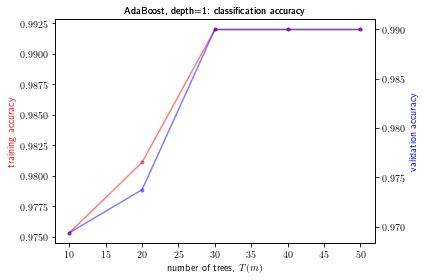

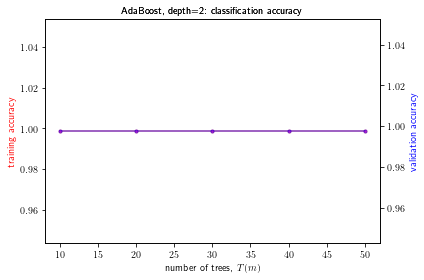

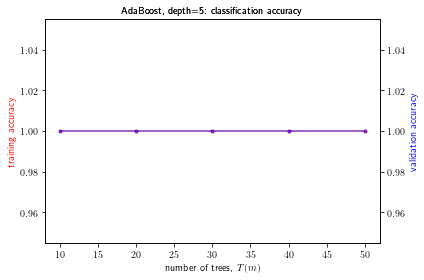

In [15]:
# Plots
print('Boosted Forest Varying Max-Depth Plot...\t')

x_T = []
x_m = []
y_trainacc = []
y_devacc = []

forestsd = mdlforests['forest']
ds = mdlforests['d']
for mdls_d,d in zip(forestsd,ds):
    fig1, ax1 = plt.subplots(figsize=(6, 4), tight_layout=True)
    ax2 = ax1.twinx()
    x_T = mdls_d['T']
    y_trainacc = mdls_d['facc_train']
    y_devacc = mdls_d['facc_dev']
    #
    ax1.plot(x_T, y_trainacc, marker='.', color='r',
             markerfacecolor='m', alpha=0.5, label=f"train")
    ax1.set_ylabel(f'training accuracy', color='r')
    ax1.set_xlabel(f"number of trees, $T(m)$")
    # ax1.legend(loc=0)
    #
    ax2.plot(x_T, y_devacc, marker='.', color='b',
             markerfacecolor='m', alpha=0.5, label=f"dev")
    ax2.set_ylabel(f'validation accuracy', color='b')

    # ax2.legend(loc=0)
    ax1.set_title(f"AdaBoost, depth={d}: classification accuracy",color='k', weight='bold', size=10)
    ax2.set_title(f"AdaBoost, depth={d}: classification accuracy",color='k', weight='bold', size=10)
    # plt.ion
    fig1.savefig(figs_dir + f"figadaboost_{d}_pt3_traindev.pdf", bbox_inches='tight')


print('Done.\n')


In [18]:
# x = sample_population(10, 4)
# x.shape[0]
# x.shape
# import numpy as np
# np.random.choice(5, 5, replace=True, p=[0.2, 0.2, 0.2, 0.2, 0.2])
# m = int(np.sqrt(cols))
# print(m)

# change d to observe, best number of trees for a particular d
# T =  50
# d = 1  #opt: T =30
# d = 2  #opt: T = 10
# d = 5  #opt: T = 30

# FOR TEST
T = 30
d = 5

# set m = 0 : no feature resampling
m = 0
randforest = AdaBoost(T)
randforest.build(DX, DY, x_names, metric_class=ent_class,
                feature_samplesize=m, max_depth=d, min_size=1, inprints=1)
print_dectree(randforest.dectrees[1])

# KAGGLE Test prediction INFERENCE
Yhat_test = randforest.infer(
            testdata['X'], testdata['Y'])

test_result = {'ID': test_id, 'Class': Yhat_test.flatten()}
dftest = pd.DataFrame(data=test_result)
dftest.to_csv(f"kaggle/mushroom-test-X-trees-{T}-depth-{d}_boost_result.csv", index=False)



OOB Estimate
class accuracy: 0.97, misses: 116
class accuracy: 0.97, misses: 116
Normalization: 1.0
tree=1

OOB Estimate
class accuracy: 0.96, misses: 193
class accuracy: 0.96, misses: 193
Normalization: 1.0
tree=2

OOB Estimate
class accuracy: 0.95, misses: 223
class accuracy: 0.95, misses: 223
Normalization: 1.0
tree=3

OOB Estimate
class accuracy: 1, misses: 11
class accuracy: 1, misses: 11
Normalization: 1.0
tree=4

OOB Estimate
class accuracy: 0.96, misses: 187
class accuracy: 0.96, misses: 187
Normalization: 1.0
tree=5

OOB Estimate
class accuracy: 0.9, misses: 438
class accuracy: 0.9, misses: 438
Normalization: 1.0
tree=6

OOB Estimate
class accuracy: 0.81, misses: 863
class accuracy: 0.81, misses: 863
Normalization: 1.0
tree=7

OOB Estimate
class accuracy: 0.87, misses: 600
class accuracy: 0.87, misses: 600
Normalization: 1.0000000000000002
tree=8

OOB Estimate
class accuracy: 1, misses: 22
class accuracy: 1, misses: 22
Normalization: 1.0
tree=9

OOB Estimate
class accuracy: 0.

In [1]:

# print(dftest.to_latex(index=False))
